# Statistical Inference

We want to create an A/B test, we want to test a simple hypothesis:

-   The podcasts with more positive sentiment in their review receive higher average ratings than podcasts with negative sentiment reviews.

To do so, and avoid biases (or p-hacking, HARKing, and so on) we will outline the steps required and proceed with them:

-   Define the hypothesis: 
    -   Null Hypothesis (H0): There is no significant difference in the average rating between positive and negative sentiment reviews.
    -   Alternative Hypothesis (H1): There is a significant difference in the average rating between positive and negative sentiment reviews.

-   Data Preparation:
    -   Split your dataset into groups: negative, positive and neutral sentiments.
    -   Compute the average review ratings for each group.

-   Statistical Test:
    -   We could use t-tests to easily compare these two differences, but we have technological tools at our disposal. Therefore, we will use bootstrapping to compare the two averages.
    -   The significance level (or alpha) used here will be of 0,05. Below this, we will consider the results of this sample not attributable to chance, and accept the alternative hypothesis.
    -   If the above is true, and we accept the alternative hypothesis, we will also check the effect size and confidence interval.

-   Visualization:
    -   The results of our AB test will be presented in a table or graph.



In [1]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import combinations
from scikit_posthocs import posthoc_dunn
import numpy as np

from py_utilities.__init__ import shapiro_wilk_and_bartlett_tests

df_folder = 'data/clean_data'


[nltk_data] Downloading package vader_lexicon to /home/alessio-
[nltk_data]     pc/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Invoking __init__.py for py_utilities
Invoking __init__.py for py_utilities.__init__


In [2]:
# Some plot styling preferences
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 14}

# Set styles for plots
qualitative_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

palette = 'crest'
style = 'darkgrid'

font = {'family': 'serif', 'size': 12}

# Set seaborn palette and style
sns.set(palette=palette, style=style, font=font)
plt.rc('font', **font)

In [3]:
ab_test_df = pd.read_pickle(f"{df_folder}/ab_test_df.pkl")

ab_test_df['word_count'] = ab_test_df['review_content'].apply(lambda x: len(nltk.word_tokenize(x)))
ab_test_df['char_count'] = ab_test_df['review_content'].apply(len)
ab_test_df['avg_word_length'] = ab_test_df.apply(lambda row: row['char_count'] / row['word_count'] if row['word_count'] > 0 else 0, axis=1)

In [4]:
ab_test_df

,podcast_title,review_title,review_content,author_id,review_created_at,avg_review_rating,effective_avg_rating,word_count,char_count,avg_word_length,sentiment,sentiment_category
0,Drink 'til We're Funny!,my favorite queer podcast,I've spent a lot of time searching for enterta...,B2DF6EF08E9D7A1,2005-12-09T21:41:01-07:00,5.0,4.772727,86,450,5.232558,0.9538,Positive
1,Democracy Now! Audio,Jackpot!!!,Suddenly having on-demand access to the entire...,220D52F1492D8B4,2005-12-09T23:39:45-07:00,5.0,4.439024,59,337,5.711864,0.9274,Positive
2,Distorted View Daily,Awesomely funny and unique podcast,This is a well done and very enjoyable podcast...,65655C518D2D0CC,2005-12-10T09:19:30-07:00,5.0,4.785536,48,200,4.166667,0.9729,Positive
3,Insight for Living Daily Broadcast,Strong messages,Chuck Swindoll's Insight for Living. Has alway...,F7EC34F784D62EE,2005-12-10T11:06:38-07:00,5.0,4.664634,124,552,4.451613,0.9815,Positive
4,Eat This Hot Show,Eat This Hot Review,5 Stars for you! One Of The Best On itunes.,BC3DD2C1DE0AEE3,2005-12-10T15:10:25-07:00,5.0,4.468750,12,43,3.583333,0.6696,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...
2042644,For the Love of Freelance,I will be binging!,Just found this podcast and I already plan to ...,EE7877B6C336602,2023-02-16T08:15:52-07:00,5.0,5.000000,46,231,5.021739,0.8298,Positive
2042645,Ruthless,One Driver at a Time!!,You guys nailed it again! Hilarious episode to...,D7377DCBB0E3A68,2023-02-16T08:24:59-07:00,5.0,4.666181,67,317,4.731343,0.8268,Positive
2042646,True Crime with Kendall Rae,Another Anti-Police host,This one actually says…”it was as if the polic...,096A4B476F3C011,2023-02-16T08:38:37-07:00,1.0,4.136531,109,480,4.403670,-0.9022,Negative
2042647,The Joe Rogan Experience,NEWS RADIO FAN 4 life,"Joe is my source for Honest, Hard Hitting Com...",3BBAB440E06A8CB,٢٠٢٠-١٢-٢٤T٠٨:٢٦:٣٦-07:00,5.0,3.737408,18,86,4.777778,0.6597,Positive


/home/alessio-pc/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/alessio-pc/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


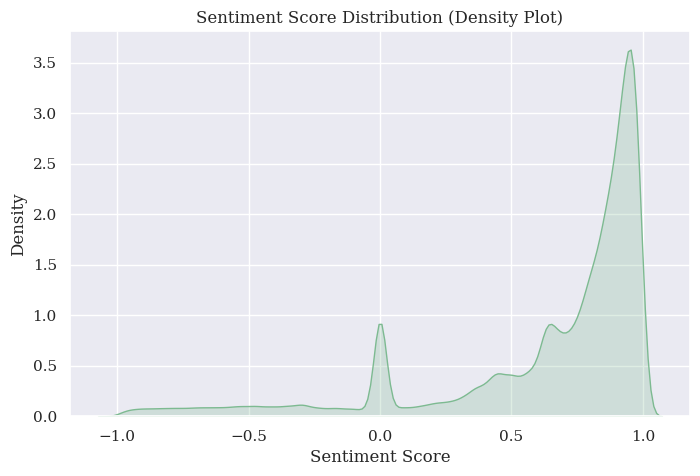

In [5]:
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores for each response higher than 2 chars
ab_test_df = ab_test_df[ab_test_df['word_count'] >= 2]
ab_test_df['sentiment'] = ab_test_df['review_content'].apply(lambda x: sia.polarity_scores(x)['compound'])


plt.figure(figsize=(8, 5))
sns.kdeplot(data=ab_test_df['sentiment'], fill=True)
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Sentiment Score Distribution (Density Plot)')
plt.show()


/home/alessio-pc/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/alessio-pc/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


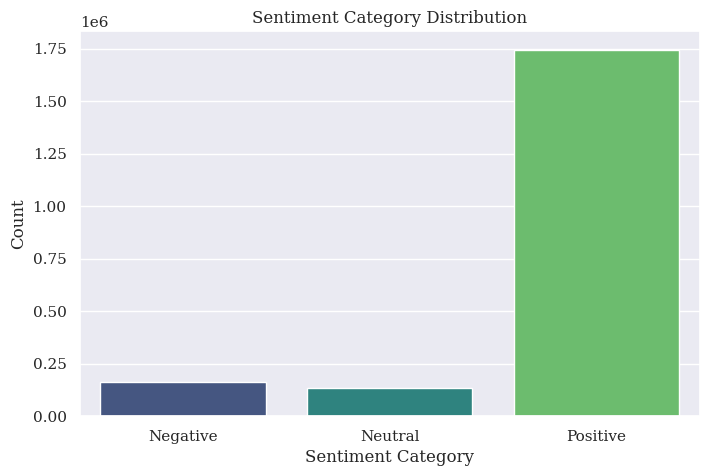

In [6]:
# Define a threshold for categorizing sentiment scores
threshold = 0.1
ab_test_df['sentiment_category'] = ab_test_df['sentiment'].apply(lambda x: 'Positive' if x > threshold else ('Negative' if x < -threshold else 'Neutral'))

plt.figure(figsize=(8, 5))
sns.countplot(data=ab_test_df, x='sentiment_category', order=['Negative', 'Neutral', 'Positive'], palette='viridis')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.title('Sentiment Category Distribution')
plt.show()


In [7]:
mask_p = ab_test_df['sentiment_category'] == 'Positive'
mask_n = ab_test_df['sentiment_category'] == 'Negative'
mask_neu = ab_test_df['sentiment_category'] == 'Neutral'
print('Reviews with positive sentiment:', ab_test_df[mask_p].shape[0])
print('Reviews with negative sentiment:', ab_test_df[mask_n].shape[0])
print('Reviews with neutral sentiment:', ab_test_df[mask_neu].shape[0])

Reviews with positive sentiment: 1745826
Reviews with negative sentiment: 161625
Reviews with neutral sentiment: 132866


Obviously, the vast majority of sentiments expressed in the review contents is positive.

Before starting with our AB test on the groups, we need to check whether they are normally distributed and/or follow homoschedasticity principles.

/home/alessio-pc/.local/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk Test Results:
Group: Positive, Shapiro Statistic: 0.8534396886825562, p-value: 0.0
Group: Negative, Shapiro Statistic: 0.9635410308837891, p-value: 0.0
Group: Neutral, Shapiro Statistic: 0.5720052719116211, p-value: 0.0

Bartlett Test Results:
Group: sentiment_category, Bartlett Statistic: 431994.1194237506, p-value: 0.0


({'Positive': {'Shapiro Statistic': 0.8534396886825562, 'p-value': 0.0},
  'Negative': {'Shapiro Statistic': 0.9635410308837891, 'p-value': 0.0},
  'Neutral': {'Shapiro Statistic': 0.5720052719116211, 'p-value': 0.0}},
 {'sentiment_category': {'Bartlett Statistic': 431994.1194237506,
   'p-value': 0.0}})

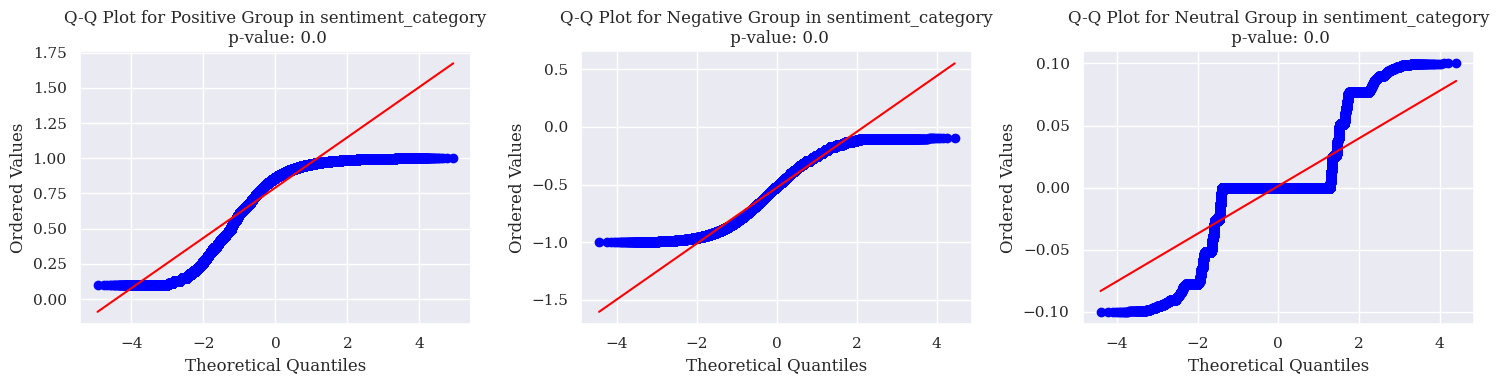

In [8]:
shapiro_wilk_and_bartlett_tests(ab_test_df, 'sentiment', 'sentiment_category')

Clearly marked by the Q-Q plot, and also visible from our tests, the data does not follow a normal distribution. We will thus have to resort to non-parametric tests, and for this dataset the choice will be Kruskal-Wallis test. We conduct a Kruskal-Wallis test to determine if there are statistically significant differences in the average ratings among the three sentiment groups (Positive, Negative, and Neutral). This test does not assume normality and is appropriate for non-normally distributed data such as this.

If the Kruskal-Wallis test indicates significant differences among the groups, we can proceed with post-hoc tests (e.g., Dunn's test) to identify which specific pairs of groups differ significantly.

In [9]:
ab_test_df.to_pickle(path=f"{df_folder}/ab_test_df.pkl")

In [10]:
ab_test_df = pd.read_pickle(f"{df_folder}/ab_test_df.pkl")

positive_ratings = ab_test_df[ab_test_df['sentiment_category'] == 'Positive']['effective_avg_rating']
negative_ratings = ab_test_df[ab_test_df['sentiment_category'] == 'Negative']['effective_avg_rating']
neutral_ratings = ab_test_df[ab_test_df['sentiment_category'] == 'Neutral']['effective_avg_rating']

statistic, p_value = stats.kruskal(positive_ratings, negative_ratings, neutral_ratings)

print(f'Kruskal-Wallis Statistic: {statistic}')
print(f'p-value: {p_value}')

alpha = 0.05
if p_value < alpha:
    print('The differences among groups are statistically significant.')
else:
    print('There is no significant difference among groups.')


Kruskal-Wallis Statistic: 100254.576324399
p-value: 0.0
The differences among groups are statistically significant.


Let's look more in detail at which specific pairs of groups differ significantly.

/home/alessio-pc/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/alessio-pc/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/alessio-pc/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


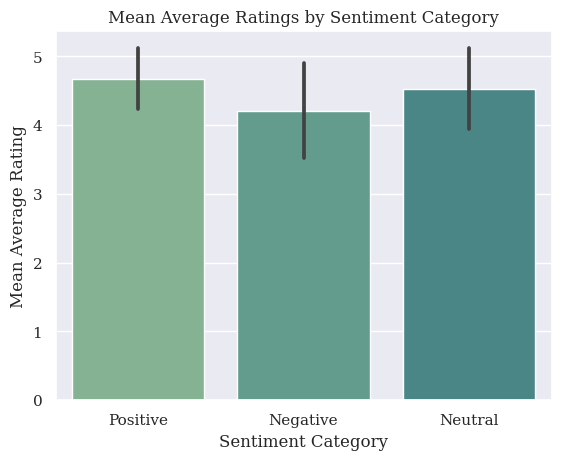

In [11]:
sns.barplot(x='sentiment_category', y='effective_avg_rating', data=ab_test_df, errorbar='sd')
plt.xlabel('Sentiment Category')
plt.ylabel('Mean Average Rating')
plt.title('Mean Average Ratings by Sentiment Category')
plt.show()


In [12]:
print("Mean Average Ratings by Sentiment Category")
ab_test_grouped = ab_test_df.groupby('sentiment_category')['effective_avg_rating'].mean()
print(ab_test_grouped)

Mean Average Ratings by Sentiment Category
sentiment_category
Negative    4.212836
Neutral     4.529364
Positive    4.673190
Name: effective_avg_rating, dtype: float64


It seems clear from here that the groups differ significantly in their mean average ratings, and the sentiment category 'Positive' is linked to higher overall ratings. But the Kruskal-Wallis test is designed to work with multiple groups. To explore the differences further, we will conduct post-hoc tests, such as Dunn's test or pairwise Wilcoxon rank-sum tests, to identify which groups are significantly different from each other.

In [13]:
sentiment_categories = ab_test_df['sentiment_category'].unique()

combinations = combinations(sentiment_categories, 2)

for group1, group2 in combinations:
    data_group1 = ab_test_df[ab_test_df['sentiment_category'] == group1]['effective_avg_rating']
    data_group2 = ab_test_df[ab_test_df['sentiment_category'] == group2]['effective_avg_rating']

    statistic, p_value = stats.mannwhitneyu(data_group1, data_group2, alternative='two-sided')

    print(f"Comparison between {group1} and {group2}:")
    print(f"Statistics: {statistic}, p-value: {p_value:.15f}")
    print()

Comparison between Positive and Negative:
Statistics: 206378681629.0, p-value: 0.000000000000000

Comparison between Positive and Neutral:
Statistics: 133074918358.0, p-value: 0.000000000000000

Comparison between Negative and Neutral:
Statistics: 7296665918.5, p-value: 0.000000000000000



The p-value indicates the probability of observing the data if there were no differences between the groups. A very low p-value, such as the ones we obtained here (essentially zero), suggests strong evidence that there are differences between the groups.

In these results:

- The p-values for all three comparisons are extremely close to zero.
- The statistics are also quite high, indicating significant differences.

We can conclude that there are statistically significant differences in average ratings among the sentiment categories. This means that the sentiment of reviews (Positive, Negative, Neutral) has an impact on the average ratings of podcasts. The results suggest that at least one of the groups is different from the others, we can do a last check with Dunn's post-hoc test.

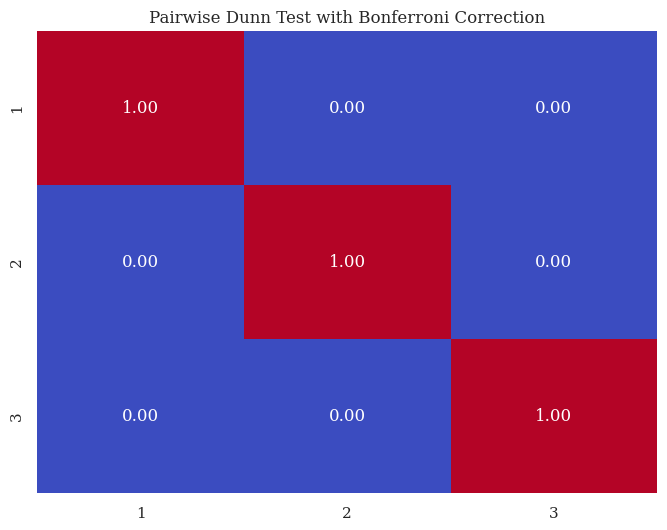

In [14]:
statistic, p_value = stats.kruskal(*[ab_test_df[ab_test_df['sentiment_category'] == group]['effective_avg_rating'] for group in sentiment_categories])

if p_value < 0.05:
    # If Kruskal-Wallis is significant, run Dunn's test for post-hoc comparisons
    dunn_results = posthoc_dunn([ab_test_df[ab_test_df['sentiment_category'] == group]['effective_avg_rating'] for group in sentiment_categories])
else:
    print("Kruskal-Wallis test did not find significant differences among groups.")

plt.figure(figsize=(8, 6))
sns.heatmap(dunn_results, annot=True, cmap='coolwarm', fmt='.2f', cbar=False)
plt.title('Pairwise Dunn Test with Bonferroni Correction')
plt.show()

- The diagonal elements (1.0) represent self-comparisons, and they are always 1.0 because we are comparing a group to itself, which should result in no difference (p-value = 1.0).

- The off-diagonal elements are the p-values for comparisons between different groups. In our case, all of these p-values are very close to 0.0 (in scientific notation). This indicates that there are statistically significant differences between the groups.

These results reiterate that there are statistically significant differences in effective average ratings between all pairs of groups (Positive, Negative, and Neutral). You can reject the null hypothesis that there is no difference between these groups in terms of effective average ratings. However, the exact magnitude of the differences or which group is higher or lower cannot be determined from the p-values alone.

We will do one last statistical check, to effectively understand how big is the magnitude of the differences we have seen thus far. To do this, we will use Cohen's D and confidence intervals.

Cohen's D:  is a common effect size measure for comparing two groups. It quantifies the difference between group means in terms of standard deviations.

Confidence Intervals:  a range of values within which the true population effect size is likely to fall. A 95% confidence interval is commonly used, as we've done here.

In [15]:
cohen_d_list = []
ci_low_list = []
ci_high_list = []

for i in range(len(sentiment_categories)):
    for j in range(i + 1, len(sentiment_categories)):
        group1 = sentiment_categories[i]
        group2 = sentiment_categories[j]

        data_group1 = ab_test_df[ab_test_df['sentiment_category'] == group1]['effective_avg_rating']
        data_group2 = ab_test_df[ab_test_df['sentiment_category'] == group2]['effective_avg_rating']

        # Calculate Cohen's d
        mean1 = np.mean(data_group1)
        mean2 = np.mean(data_group2)
        std1 = np.std(data_group1, ddof=1)  # Use ddof=1 for sample standard deviation
        std2 = np.std(data_group2, ddof=1)
        n1 = len(data_group1)
        n2 = len(data_group2)

        pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
        cohen_d = (mean1 - mean2) / pooled_std

        ci_low = cohen_d - 1.96 * (pooled_std / np.sqrt(n1))
        ci_high = cohen_d + 1.96 * (pooled_std / np.sqrt(n1))

        cohen_d_list.append(cohen_d)
        ci_low_list.append(ci_low)
        ci_high_list.append(ci_high)

# Print the results
for i in range(len(sentiment_categories)):
    for j in range(i + 1, len(sentiment_categories)):
        group1 = sentiment_categories[i]
        group2 = sentiment_categories[j]
        index = f"Comparison between {group1} and {group2}"
        print(f"{index}:\nCohen's d: {cohen_d_list.pop(0):.4f}")
        print(f"95% CI for Cohen's d: ({ci_low_list.pop(0):.4f}, {ci_high_list.pop(0):.4f})\n")


Comparison between Positive and Negative:
Cohen's d: 0.9765
95% CI for Cohen's d: (0.9758, 0.9772)

Comparison between Positive and Neutral:
Cohen's d: 0.3149
95% CI for Cohen's d: (0.3143, 0.3156)

Comparison between Negative and Neutral:
Cohen's d: -0.4880
95% CI for Cohen's d: (-0.4911, -0.4848)



Let's now save a portion of this dataset, so that we can create reports from it in Google Data Studio.

In [16]:
# last 2 rows have invalid values, then make datetime
ab_test_df = ab_test_df.iloc[:-2]
ab_test_df['review_created_at'] = pd.to_datetime(ab_test_df['review_created_at'])

In [17]:
ab_test_df.drop(columns=['review_content','review_title']).iloc[:350000].to_csv(f"{df_folder}/google_studio_df.csv", index=False, header=True)

The results from the calculation of Cohen's d and 95% confidence intervals provide information about the effect size and the magnitude of differences between the sentiment categories.

Comparison between Positive and Negative:

- The Cohen's d value of approximately 0.9765 indicates a large effect size. This suggests a substantial difference in the average effective ratings between podcasts with positive and negative sentiment reviews. The 95% confidence interval (0.9758, 0.9772) confirms that this difference is highly significant.

Comparison between Positive and Neutral:

- The Cohen's d value of approximately 0.3149 indicates a medium effect size. This suggests a moderate difference in the average effective ratings between podcasts with positive and neutral sentiment reviews. The 95% confidence interval (0.3143, 0.3156) confirms that this difference is statistically significant.

Comparison between Negative and Neutral:

- The Cohen's d value of approximately -0.4880 indicates a large effect size, similar to the positive-negative comparison. However, the negative sign suggests that podcasts with negative sentiment reviews have lower average effective ratings compared to those with neutral sentiment reviews. The 95% confidence interval (-0.4911, -0.4848) confirms this significant difference.


In summary, these results suggest that there are significant and substantial differences in average effective ratings between podcasts with different sentiment reviews. The effect sizes (Cohen's d) provide information about the magnitude of these differences, and the confidence intervals confirm the statistical significance. To finalize, we have shown how Positive reviews are significantly more effective than Negative reviews, and Negative reviews are significantly less effective than Neutral reviews.

